# Recommender system for books

Изработиле: Марија Савеска 201062, Давид Арсовски 206003

Во наредните делови ќе разгледуваме креирање на систем за препорака на книги, каде ќе ги опфатиме сите клучни чекори за неговото создавање.

Податоците се превземени од Kaggle
https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews/data?select=books_data.csv, а искористен е само еден дел од ова масивно податочно множество.

Податоците ги имаме визуелизирано за читателот да има појасна слика за каков тип на податоци станува збор, како и за помош при прочистувањето на податоците и нивно намалување.
Во истиот овој дел правиме анализа на сентиментот за да имаме појасна слика за податоците.

Понатаму, ги екстрахираме сите битни својства од податоците, како што се жанрот на книгите, автор и издавач.
Користејќи ги името и описот на книгите, го употребуавме RoBERTa моделот за додавање на векторска претстава за истите.

Со тоа, следен чекор е создавањето на графот користејќи Pytorch Geometric. Со тоа создаваме компјутерска претстава на нашиот граф на знаење врз кој понатаму ќе ги тренираме и тестираме моделите - GraphSAGE, GAТ и Transformers. После долг период тренирање - ги тестираме и правиме споредба на сите модели користејќи ја hit метриката. Од нашите резултати добиваме високо ниво на прецизност и добар знак дека овој проблем би можел да биде (и веќе е) корисен и користен во вистинскиот живот на огромен број на податоци од различни сфери.


# Loading libraries

In [ ]:
!pip install transformers
!pip install vaderSentiment
!pip install kaggle
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch import tensor
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 53.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 26.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.8 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-48_mjag7
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-48_mjag7
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 476e768593d91c1622b02440e25bbc93fc7f5294
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.6.0-py3-none-any.whl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import exists

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

from transformers import RobertaTokenizer, RobertaModel

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
import torch_geometric.transforms as T

%matplotlib inline

#Loading dataset

In [ ]:
!gdown 1P5czAPpwVkIoQVbvhi4yg7mj2V11W8jU

Downloading...
From: https://drive.google.com/uc?id=1P5czAPpwVkIoQVbvhi4yg7mj2V11W8jU
To: /content/kaggle.json
100% 65.0/65.0 [00:00<00:00, 381kB/s]


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:16<00:00, 80.4MB/s]
100% 1.06G/1.06G [00:16<00:00, 67.7MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('amazon-books-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset-folder')

In [ ]:
original_ratings = pd.read_csv("dataset-folder/Books_rating.csv")

In [ ]:
original_books = pd.read_csv("dataset-folder/books_data.csv")

#Data preprocessing

## Merging ratings and books datasets

In [ ]:
books = pd.merge(original_ratings, original_books, on='Title')

In [ ]:
books.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN


## Handling missing values

In [ ]:
books.isnull().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
description            640225
authors                390634
image                  540306
previewLink            330623
publisher              782617
publishedDate          354581
infoLink               330623
categories             551498
ratingsCount          1360694
dtype: int64

In [ ]:
books = books.dropna(subset=["Title", "User_id"])

In [ ]:
books = books.drop(["Price", "ratingsCount", "previewLink", "infoLink", "profileName" ,"review/helpfulness"], axis=1)

## Filtering dataset to reduce dimensionality

In [ ]:
books.drop_duplicates(inplace = True)

In [ ]:
#Filtering only users that have more than 10 reviews

user_review_counts = books.groupby('User_id').size()
users_more_than_10 = user_review_counts[user_review_counts > 10].index.tolist()
books_filtered = books[books["User_id"].isin(users_more_than_10)]

In [ ]:
#Filtering reviews that have a higher score than 3
books_filtered = books_filtered[books_filtered["review/score"] >= 3]

In [ ]:
#Filtering books that have 7 or more reviews
books_filtered = books_filtered.groupby('Title').filter(lambda x: len(x) > 7)

In [ ]:
#Filtering books that only have one author
books_filtered['num_authors'] = books_filtered['authors'].astype(str).apply(lambda x: len(x.split(',')))
books_filtered = books_filtered[books_filtered['num_authors'] <= 1].drop(columns=['num_authors'])

In [ ]:
#Filtering books that only have one category
books_filtered['num_categories'] = books_filtered['categories'].astype(str).apply(lambda x: len(x.split(',')))
books_filtered = books_filtered[books_filtered['num_categories'] <= 1].drop(columns=['num_categories'])

In [ ]:
books_filtered.head()

,Id,Title,User_id,review/score,review/time,review/summary,review/text,description,authors,image,publisher,publishedDate,categories
588,B000N7612G,The Food Of Love,A2V6FC7GVZ6T7M,5.0,1285459200,The Food of Love,A tale of tangled relationships and excellent ...,Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],http://books.google.com/books/content?id=pyFZA...,Boekerij,2013-12-17,['Fiction']
589,B000N7612G,The Food Of Love,A1ZMXRS5770YKG,4.0,1269648000,A Taste of Italy,Longing for vicarious travel? Imagining your c...,Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],http://books.google.com/books/content?id=pyFZA...,Boekerij,2013-12-17,['Fiction']
599,B000N7612G,The Food Of Love,A2XY7UO3HTBFLF,5.0,1151712000,simply delicious,"This is a very sensual book, bringing to life ...",Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],http://books.google.com/books/content?id=pyFZA...,Boekerij,2013-12-17,['Fiction']
607,B000N7612G,The Food Of Love,AKPQSBU4BZNZY,4.0,1111622400,Cameriere!,I enjoyed this book-- it was much better than ...,Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],http://books.google.com/books/content?id=pyFZA...,Boekerij,2013-12-17,['Fiction']
609,B000N7612G,The Food Of Love,A1HS3BUBNZJJD6,5.0,1096848000,Delicioso; virtuoso; bellissimo!,"Food, especially Italian food, and love. Just ...",Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],http://books.google.com/books/content?id=pyFZA...,Boekerij,2013-12-17,['Fiction']


In [ ]:
books_filtered.value_counts("User_id")

User_id
A1D2C0WDCSHUWZ    2612
AFVQZQ8PW0L       1430
A20EEWWSFMZ1PN    1032
A1X8VZWTOG8IS6     956
AHD101501WCN1      850
                  ... 
A26583WRXQNXW5       1
AHW8JTCTZTR9Y        1
AEODQJKFYQ7MF        1
A2YOGE3CF7BQR1       1
A21GR1V14M2YE        1
Name: count, Length: 24649, dtype: int64

In [ ]:
books_filtered.isnull().sum()

Id                     0
Title                  0
User_id                0
review/score           0
review/time            0
review/summary        97
review/text            0
description       105874
authors            62422
image              82283
publisher         122666
publishedDate      64012
categories        112683
dtype: int64

In [ ]:
books_filtered.shape

(491723, 13)

In [ ]:
unique_books = books_filtered.drop_duplicates(subset=['Title'])

In [ ]:
unique_books.head()

,Id,Title,User_id,review/score,review/time,review/summary,review/text,description,authors,image,publisher,publishedDate,categories
588,B000N7612G,The Food Of Love,A2V6FC7GVZ6T7M,5.0,1285459200,The Food of Love,A tale of tangled relationships and excellent ...,Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],http://books.google.com/books/content?id=pyFZA...,Boekerij,2013-12-17,['Fiction']
755,050552421X,The Scarletti Curse (Candleglow),AHN0MGJYQHQBJ,5.0,985046400,Fabulous...,"This book was awesome. A fast paced, riveting ...",NaN,['Christine Feehan'],NaN,NaN,NaN,NaN
860,B000MCKQRS,Cruel and Unusual (G K Hall Large Print Book S...,A2HO898G5N5X05,5.0,1285200000,Plenty of Twists and Turns,"First off, let me say that although all of Cor...",Wanneer er in dit achtste deel in de Kay Scarp...,['Patricia Cornwell'],http://books.google.com/books/content?id=AgckD...,Luitingh Sijthoff,2017-06-01,['Fiction']
992,0375422811,The Rabbi's Cat,A3F7XLGCTTUMWP,4.0,1137283200,Tremendously entertaining mixture of fable and...,This is a very entertaining tale of a clever c...,Gaining the ability to speak after swallowing ...,['Joann Sfar'],http://books.google.com/books/content?id=cNQbA...,Pantheon,2005,['Comics & Graphic Novels']
1071,B000O3QCH8,From Potter's Field,A1N1YEMTI9DJ86,4.0,1066608000,Do we Finally See the End of Temple Gault?,"I read a lot of the reveiws, and I don't agree...","The sixth book in the Kay Scarpetta series, fr...",['Patricia Cornwell'],http://books.google.com/books/content?id=prefg...,Hachette UK,2008-09-04,['Fiction']


In [ ]:
unique_books.shape

(10776, 13)

In [ ]:
unique_books['Title'].nunique()

10776

In [ ]:
unique_books['categories'].value_counts().head(10)

categories
['Fiction']                      4094
['Juvenile Fiction']              506
['Biography & Autobiography']     505
['History']                       451
['Religion']                      317
['Business & Economics']          183
['Social Science']                116
['Philosophy']                    111
['Political Science']             103
['Young Adult Fiction']            92
Name: count, dtype: int64

##Visualizations

This visualization represents how many books of each genre we have in our dataset, using a pie chart

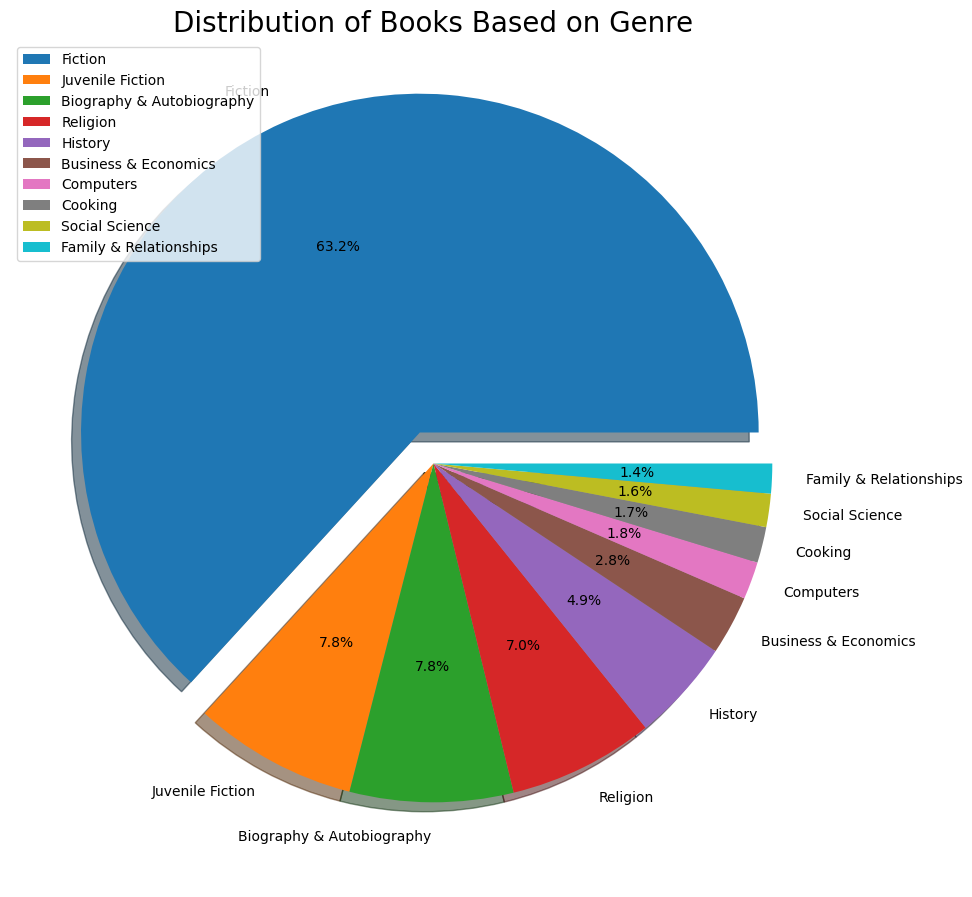

In [ ]:
plt.figure(figsize=(11,11
                    ))
labels=['Fiction','Juvenile Fiction','Biography & Autobiography','Religion','History','Business & Economics','Computers','Cooking','Social Science','Family & Relationships']
plt.pie(unique_books['categories'].value_counts().head(10),explode=(0.1,0,0,0,0,0,0,0,0,0), labels=labels,autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Books Based on Genre', fontsize = 20)
plt.axis('off')
plt.legend(loc='upper left')
plt.show()



---



In [ ]:
category_visual = books.dropna(subset=["categories"])

In [ ]:
category_visual = category_visual.groupby('categories').filter(lambda x: len(x) > 10000)

Visualizing the average rating based on the genre of the books

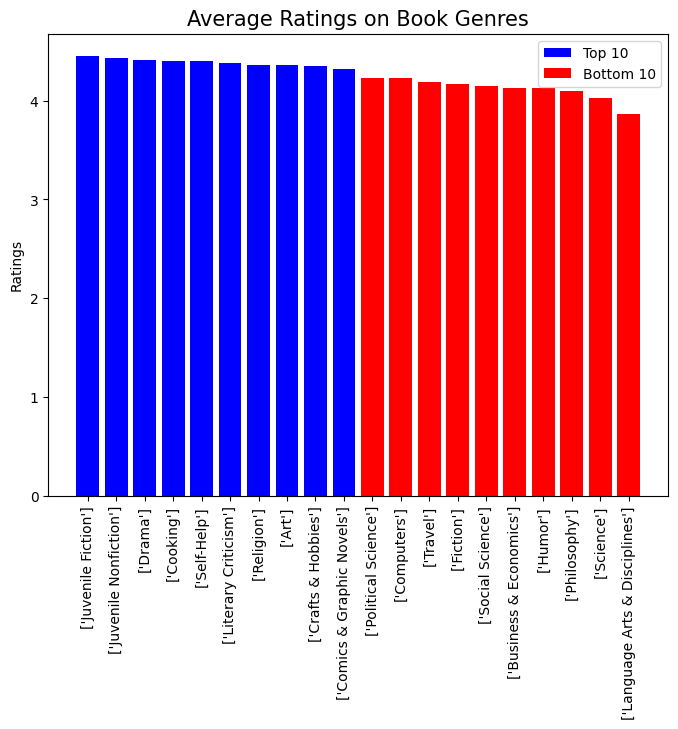

In [ ]:
avg_cat_rating = category_visual.groupby('categories')['review/score'].mean().sort_values(ascending=False).head(10)
avg_cat_rating_d = category_visual.groupby('categories')['review/score'].mean().sort_values().head(10)

plt.figure(figsize=(8, 6))
plt.bar(avg_cat_rating.index, avg_cat_rating, color='blue', label='Top 10')
plt.bar(avg_cat_rating_d.index, avg_cat_rating_d[::-1], color='red', label='Bottom 10')
plt.title('Average Ratings on Book Genres', fontsize=15)
plt.xticks(rotation='vertical')
plt.ylabel('Ratings')
plt.legend()
plt.show()



---



In [ ]:
book_sample = books_filtered.sample(100000)

In [ ]:
book_sample.isnull().sum()

Id                    0
Title                 0
User_id               0
review/score          0
review/time           0
review/summary       16
review/text           0
description       21582
authors           12663
image             16682
publisher         24947
publishedDate     12964
categories        23020
dtype: int64

In [ ]:
book_sample = book_sample.reset_index()

Visualizing the number of reviews for a given book

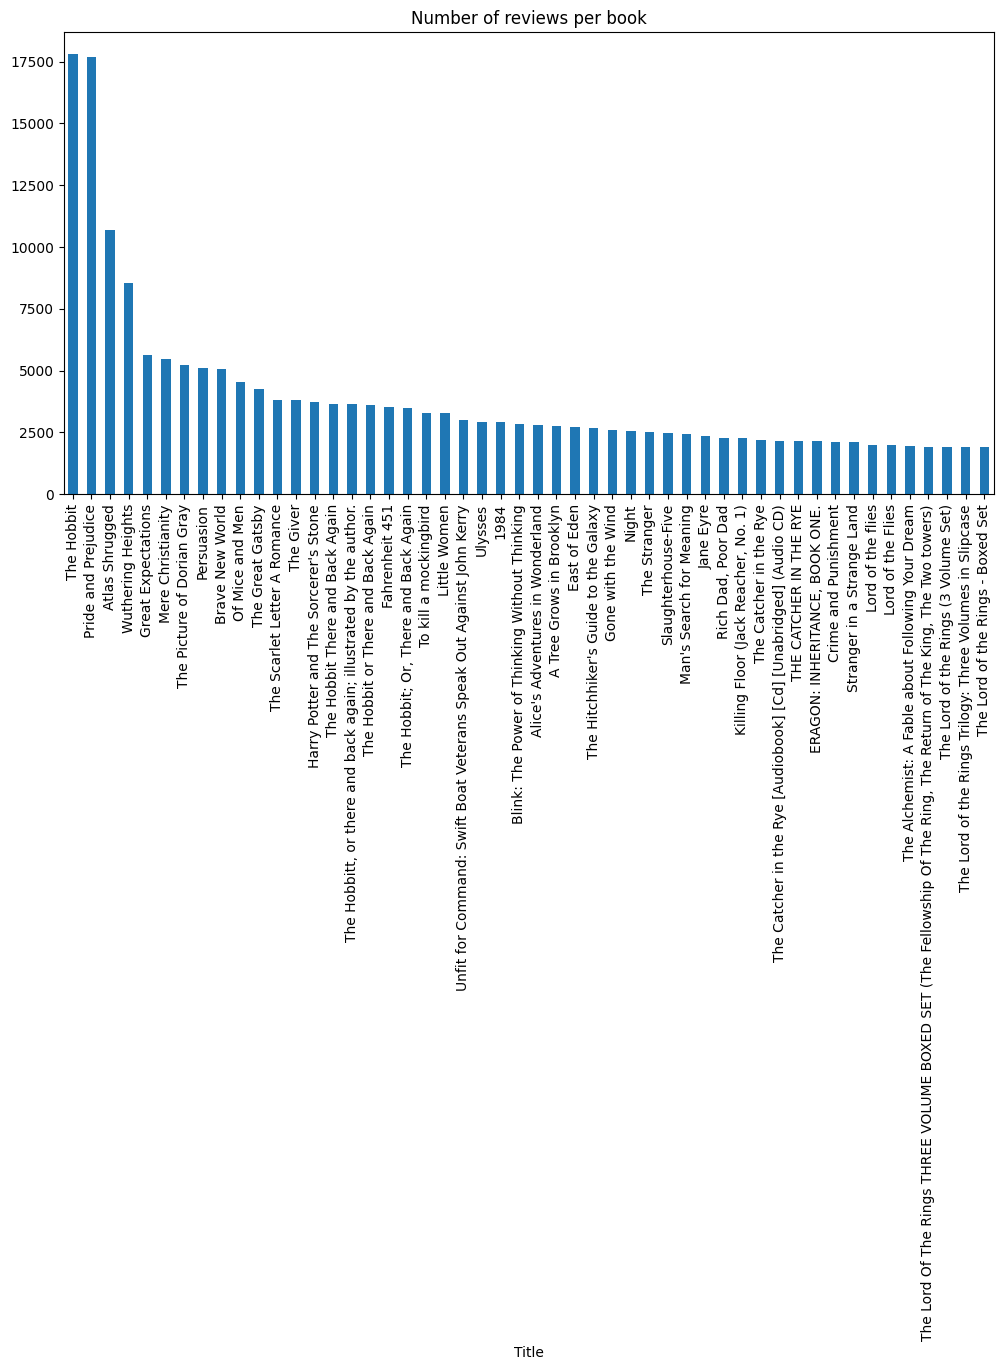

In [ ]:
plt.figure(figsize=(12, 6))
books.value_counts("Title")[:50].plot(kind='bar')

plt.title('Number of reviews per book')
plt.show()




---



Graphing the most active users by number of reviews

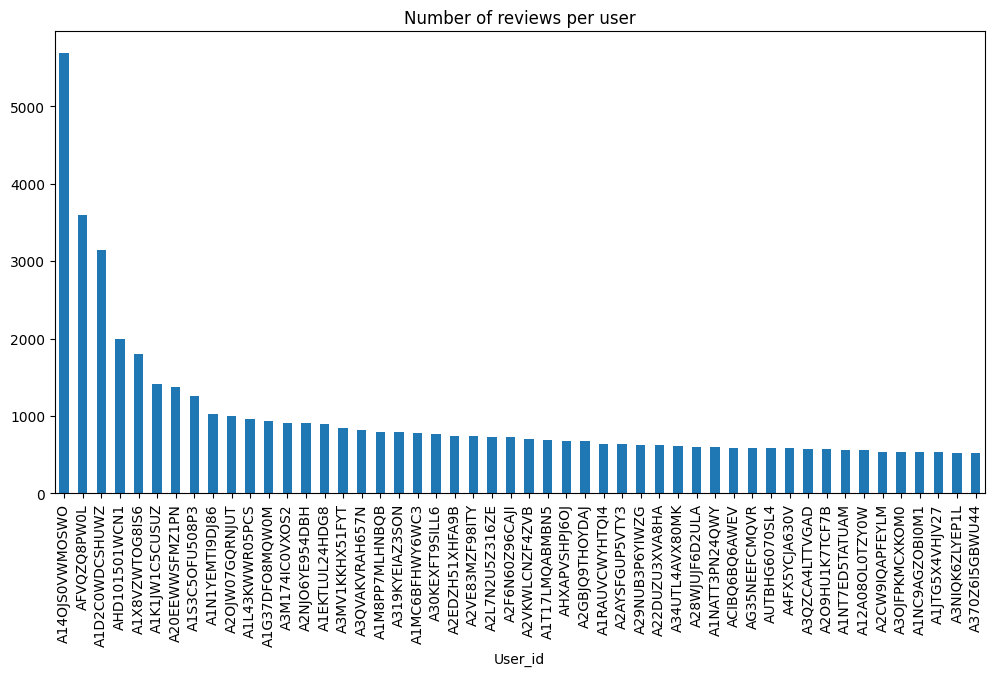

In [ ]:
plt.figure(figsize=(12, 6))
books.value_counts("User_id")[:50].plot(kind='bar')

plt.title('Number of reviews per user')
plt.show()


---



Graphing the highest and lowest reviewed book with more than 1000 reviews

In [ ]:
most_reviewed_books = books.groupby('Title').filter(lambda x: len(x) > 1000)

In [ ]:
average_review_scores = most_reviewed_books.groupby('Title')['review/score'].mean().sort_values(ascending=False).head(25)
average_review_scores_d = most_reviewed_books.groupby('Title')['review/score'].mean().sort_values().head(25)

<ipython-input-43-e5896add42af>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels, rotation=90)


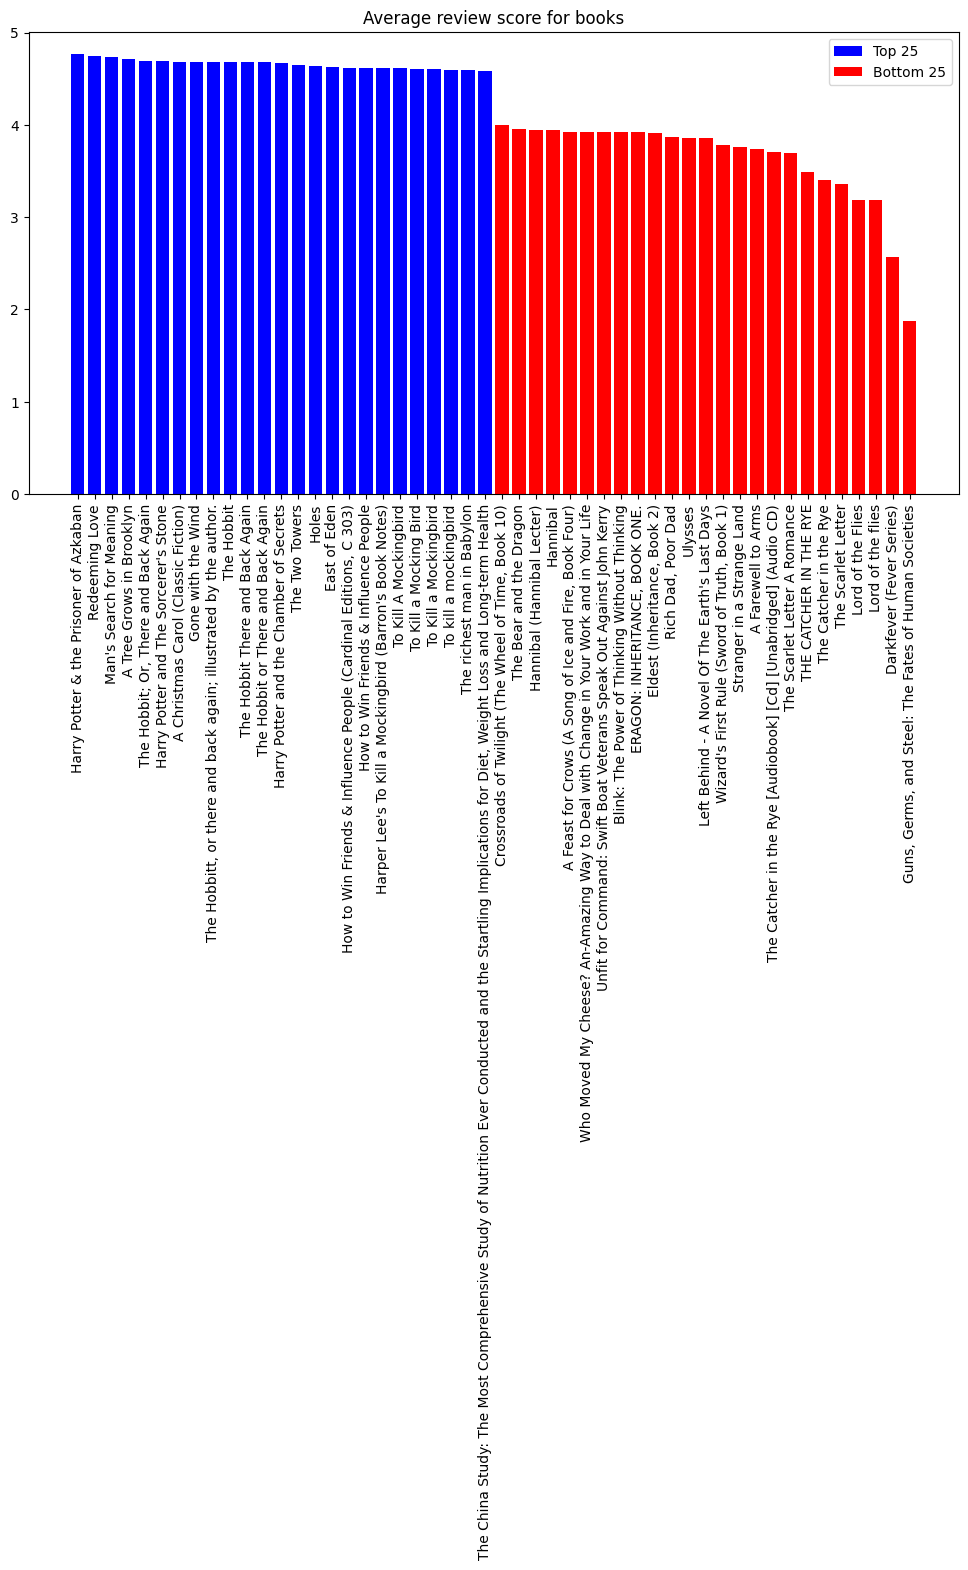

In [ ]:
plt.figure(figsize=(12, 6))

plt.bar(average_review_scores.index, average_review_scores, color='blue', label='Top 25')
plt.bar(average_review_scores_d.index, average_review_scores_d[::-1], color='red', label='Bottom 25')

plt.legend()
plt.title('Average review score for books')

labels = average_review_scores.index.append( average_review_scores_d.index)
plt.gca().set_xticklabels(labels, rotation=90)
plt.show()

##Sentiment Analysis

In [ ]:
review_sample = books.sample(10000)

In [ ]:
vader = SentimentIntensityAnalyzer()

In [ ]:
# Lower casing the reviews
review_sample['clean_reviews'] = review_sample['review/text'].str.lower()
# Calculating Polarity score of reviews
review_sample['score'] = review_sample['clean_reviews'].apply(lambda review: vader.polarity_scores(review))
# Extracting compound column
review_sample['compound']  = review_sample['score'].apply(lambda score_dict: score_dict['compound'])

In [ ]:
review_sample.head(2)

,Id,Title,User_id,review/score,review/time,review/summary,review/text,description,authors,image,publisher,publishedDate,categories,clean_reviews,score,compound
2048450,1586420771,"I Heard You Paint Houses: Frank ""The Irishman""...",AZWW1U604W0N,5.0,1149206400,I Heard You Tell Whoppers,Degenerate killer and reprobate Frank Sheeran ...,"The inspiration for the major motion picture, ...",['Charles Brandt'],http://books.google.com/books/content?id=kipLD...,Steerforth,2016-06-24,['True Crime'],degenerate killer and reprobate frank sheeran ...,"{'neg': 0.143, 'neu': 0.768, 'pos': 0.09, 'com...",-0.9670
831597,B0006AYMHG,The deer hunter's bible,A6NKNPMZM0Y61,5.0,1218672000,wigglestick,This is a good book. It is not up to date with...,Describes the weapons and skills most effectiv...,['George Laycock'],http://books.google.com/books/content?id=UTkwi...,Main Street Books,1986,['Sports & Recreation'],this is a good book. it is not up to date with...,"{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'comp...",0.8641


In [ ]:
review_sample['Sentiment'] = review_sample['compound'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x < -0.05 else 'neutral')
review_sample.head(2)

,Id,Title,User_id,review/score,review/time,review/summary,review/text,description,authors,image,publisher,publishedDate,categories,clean_reviews,score,compound,Sentiment
2048450,1586420771,"I Heard You Paint Houses: Frank ""The Irishman""...",AZWW1U604W0N,5.0,1149206400,I Heard You Tell Whoppers,Degenerate killer and reprobate Frank Sheeran ...,"The inspiration for the major motion picture, ...",['Charles Brandt'],http://books.google.com/books/content?id=kipLD...,Steerforth,2016-06-24,['True Crime'],degenerate killer and reprobate frank sheeran ...,"{'neg': 0.143, 'neu': 0.768, 'pos': 0.09, 'com...",-0.9670,negative
831597,B0006AYMHG,The deer hunter's bible,A6NKNPMZM0Y61,5.0,1218672000,wigglestick,This is a good book. It is not up to date with...,Describes the weapons and skills most effectiv...,['George Laycock'],http://books.google.com/books/content?id=UTkwi...,Main Street Books,1986,['Sports & Recreation'],this is a good book. it is not up to date with...,"{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'comp...",0.8641,positive


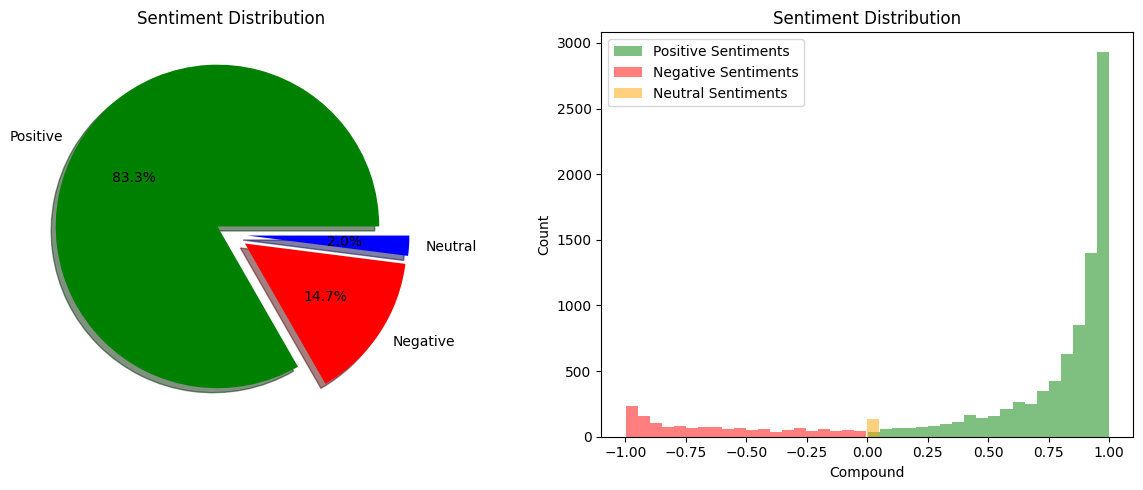

In [ ]:
# Creating a figure and subplots with 1 row and 2 columns
plt.figure(figsize=(12, 5))

# Plot 1 - Pie chart for sentiment distribution
plt.subplot(1, 2, 1)
labels = ['Positive', 'Negative', 'Neutral']
sizes = review_sample['Sentiment'].value_counts()
colors = ['green', 'red', 'blue']
explode = (0.1, 0.1, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title('Sentiment Distribution')

# Plot 2 - Histogram for sentiment distribution
plt.subplot(1, 2, 2)
positive = review_sample[review_sample['compound'] > 0]['compound']
negative = review_sample[review_sample['compound'] < 0]['compound']
neutral = review_sample[review_sample['compound'] == 0]['compound']

sentiments = [positive, negative, neutral]
colors = ['green', 'red', 'orange']
labels = ['Positive Sentiments', 'Negative Sentiments', 'Neutral Sentiments']

for sentiment, color, label in zip(sentiments, colors, labels):
    plt.hist(sentiment, bins=20, color=color, alpha=0.5, label=label)

plt.title('Sentiment Distribution')
plt.xlabel('Compound')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

##Feature extraction

In [ ]:
unique_books = unique_books.reset_index(drop=True)

In [ ]:
unique_books = unique_books.drop(["Id","User_id","review/score","review/time","review/summary","review/text","image","publishedDate"],axis=1)

In [ ]:
unique_books.head(5)

,Title,description,authors,publisher,categories
0,The Food Of Love,Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],Boekerij,['Fiction']
1,The Scarletti Curse (Candleglow),NaN,['Christine Feehan'],NaN,NaN
2,Cruel and Unusual (G K Hall Large Print Book S...,Wanneer er in dit achtste deel in de Kay Scarp...,['Patricia Cornwell'],Luitingh Sijthoff,['Fiction']
3,The Rabbi's Cat,Gaining the ability to speak after swallowing ...,['Joann Sfar'],Pantheon,['Comics & Graphic Novels']
4,From Potter's Field,"The sixth book in the Kay Scarpetta series, fr...",['Patricia Cornwell'],Hachette UK,['Fiction']


In [ ]:
id_to_book_title = {}
book_title_to_id = {}

In [ ]:
for i, row in enumerate(unique_books.values):

  id_to_book_title[i] = row[0]
  book_title_to_id[row[0]] = i

In [ ]:
id_to_book_title

{0: 'The Food Of Love',
 1: 'The Scarletti Curse (Candleglow)',
 2: 'Cruel and Unusual (G K Hall Large Print Book Series (Cloth))',
 3: "The Rabbi's Cat",
 4: "From Potter's Field",
 5: 'Lincoln reconsidered;: Essays on the Civil War era',
 6: 'Economics in one lesson',
 7: 'Tales from silver lands',
 8: 'Edge of Danger',
 9: 'The Scarlet Letter A Romance',
 10: 'Olympic Wandering: Time Travel Through Greece',
 11: "Plain And Simple - A Woman's Journey To The Amish",
 12: 'Thomas Paine : Collected Writings : Common Sense / The Crisis / Rights of Man / The Age of Reason / Pamphlets, Articles, and Letters (Library of America)',
 13: 'The Castle in the Attic',
 14: 'Outposts',
 15: 'Island',
 16: 'Life with father',
 17: 'After the Fire (Chivers Sound Library)',
 18: 'Stuck with You (Time of Your Life)',
 19: 'Dumb witness',
 20: 'Professional collection catalog',
 21: "Lenin's Tomb: The Last Days of the Soviet Empire",
 22: "Dr. Bernstein's Diabetes Solution: The Complete Guide to Achiev

In [ ]:
encoder = LabelEncoder()

encoder.fit(unique_books["publisher"])

unique_books["publisher_id"] = encoder.transform(unique_books["publisher"])

In [ ]:
encoder = LabelEncoder()

encoder.fit(unique_books["authors"])

unique_books["author_id"] = encoder.transform(unique_books["authors"])

In [ ]:
encoder = LabelEncoder()

encoder.fit(unique_books["categories"])

unique_books["category_id"] = encoder.transform(unique_books["categories"])


In [ ]:
unique_books.head(2)

,Title,description,authors,publisher,categories,publisher_id,author_id,category_id
0,The Food Of Love,Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],Boekerij,['Fiction'],171,307,342
1,The Scarletti Curse (Candleglow),NaN,['Christine Feehan'],NaN,NaN,1342,777,596


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to compute mean embeddings for titles or descriptions
def compute_embeddings(texts):
    embeddings_list = []

    batch_size = 1000

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        print(f"Currently processing {i}")
        # Tokenizing and preprocesing texts
        tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in batch_texts.astype(str)]

        # Padding or truncating tokenized sequences to a fixed length
        max_length = 128
        padded_texts = [text[:max_length] + [tokenizer.pad_token_id] * (max_length - len(text[:max_length])) for text in tokenized_texts]

        # Converting to PyTorch tensors
        input_ids = torch.tensor(padded_texts).to(device)

        # Generating RoBERTa embeddings
        with torch.no_grad():
            outputs = model(input_ids)
            embeddings = outputs.last_hidden_state[:, 0, :].to(device)  # Extracting embeddings

        embeddings_list.extend(embeddings.cpu().numpy())

    return embeddings_list



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
book_features = unique_books[['publisher_id', 'author_id', 'category_id']].copy()

In [ ]:
!gdown 1vGYNRLtHIQxrNmSVL8Bb5Uiu6APTxkgd
!gdown 1K__036ootIGd5PsxWNVVh2MK5NkWw1QD

Downloading...
From: https://drive.google.com/uc?id=1vGYNRLtHIQxrNmSVL8Bb5Uiu6APTxkgd
To: /content/mean_title_embeddings.csv
100% 1.21M/1.21M [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1K__036ootIGd5PsxWNVVh2MK5NkWw1QD
To: /content/mean_description_embeddings.csv
100% 1.12M/1.12M [00:00<00:00, 115MB/s]


In [ ]:
title_embeddings = compute_embeddings(unique_books["Title"])
description_embeddings = compute_embeddings(unique_books["description"])

Currently processing 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Currently processing 1000
Currently processing 2000
Currently processing 3000
Currently processing 4000
Currently processing 5000
Currently processing 6000
Currently processing 7000
Currently processing 8000
Currently processing 9000
Currently processing 10000


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


Currently processing 0
Currently processing 1000
Currently processing 2000
Currently processing 3000
Currently processing 4000
Currently processing 5000
Currently processing 6000
Currently processing 7000
Currently processing 8000
Currently processing 9000
Currently processing 10000


In [ ]:
title_embeddings_df = pd.DataFrame(title_embeddings)
description_embeddings_df = pd.DataFrame(description_embeddings)

In [ ]:
title_embeddings_df.to_csv("title_embeddings.csv")
description_embeddings_df.to_csv("description_embeddings.csv")

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# We reduce the dimensionality of the RoBERTa embeddings for title and description

title_embeddings_number = 4
description_embeddings_number = 16

# Creating a PCA object
pca_title = PCA(n_components=title_embeddings_number)

# Fitting the PCA model on the embeddings
reduced_embeddings_title = pca_title.fit_transform(title_embeddings_df)


pca_description = PCA(n_components=description_embeddings_number)

reduced_embeddings_description = pca_description.fit_transform(description_embeddings_df)

In [ ]:
reduced_embeddings_title_df = pd.DataFrame(reduced_embeddings_title)
reduced_embeddings_description_df = pd.DataFrame(reduced_embeddings_description)

In [ ]:
for i in range(title_embeddings_number):
  reduced_embeddings_title_df.rename(columns={i:f"title_embedding_{i}"}, inplace=True)

for i in range(description_embeddings_number):
  reduced_embeddings_description_df.rename(columns={i:f"description_embedding_{i}"}, inplace=True)

In [ ]:
reduced_embeddings_title_df.head()

,title_embedding_0,title_embedding_1,title_embedding_2,title_embedding_3
0,-0.512386,-0.236635,-0.045699,0.008932
1,1.131516,-0.727071,0.161241,-0.045131
2,-0.431889,0.005770,0.714754,-0.444568
3,0.076702,-0.682863,-0.514670,-0.128455
4,-1.087672,-0.007102,-0.055304,-0.038627


In [ ]:
reduced_embeddings_description_df.head()

,description_embedding_0,description_embedding_1,description_embedding_2,description_embedding_3,description_embedding_4,description_embedding_5,description_embedding_6,description_embedding_7,description_embedding_8,description_embedding_9,description_embedding_10,description_embedding_11,description_embedding_12,description_embedding_13,description_embedding_14,description_embedding_15
0,-0.592102,-0.262233,-0.204606,-0.159229,0.095746,-0.011702,0.083032,-0.168890,0.224070,0.605691,-0.224251,-0.047731,0.250465,0.113364,0.500224,-0.220370
1,1.842212,-0.308640,0.214497,-0.107944,0.055611,0.043954,0.009478,-0.005620,0.005207,-0.006068,-0.001719,-0.002759,0.004707,-0.006715,-0.001541,0.000279
2,-0.784786,-0.347286,-0.122915,-0.115359,0.071987,0.046521,0.155574,-0.166134,0.211037,0.578335,-0.189465,-0.037642,0.210593,0.117450,0.528488,-0.267018
3,0.097835,0.954007,-0.407950,-0.350501,-0.572399,0.115953,-0.044199,0.028963,0.111849,-0.153720,-0.154625,0.024641,-0.059896,0.002818,-0.000368,-0.042545
4,-0.185819,-0.617992,-0.576369,-0.034132,-0.054087,-0.069306,-0.219292,0.000419,0.080835,0.044311,0.090887,0.015911,-0.095225,-0.114765,-0.039994,0.016848


In [ ]:
# Computing mean embeddings for titles and descriptions
if not(exists("mean_title_embeddings.csv") and exists("mean_description_embeddings.csv") ):
  mean_title_embeddings = compute_mean_embeddings(unique_books["Title"])
  mean_description_embeddings = compute_mean_embeddings(unique_books["description"])
else:
  mean_title_embeddings = pd.read_csv("mean_title_embeddings.csv")
  mean_description_embeddings = pd.read_csv("mean_description_embeddings.csv")



In [ ]:
#Concatinating existing book features with title and description embeddings
result_book_features = pd.concat([book_features, reduced_embeddings_description_df, reduced_embeddings_title_df], axis=1)

In [ ]:
result_book_features

,publisher_id,author_id,category_id,description_embedding_0,description_embedding_1,description_embedding_2,description_embedding_3,description_embedding_4,description_embedding_5,description_embedding_6,...,description_embedding_10,description_embedding_11,description_embedding_12,description_embedding_13,description_embedding_14,description_embedding_15,title_embedding_0,title_embedding_1,title_embedding_2,title_embedding_3
0,171,307,342,-0.592102,-0.262233,-0.204606,-0.159229,0.095746,-0.011702,0.083032,...,-0.224251,-0.047731,0.250465,0.113364,0.500224,-0.220370,-0.512386,-0.236635,-0.045699,0.008932
1,1342,777,596,1.842212,-0.308640,0.214497,-0.107944,0.055611,0.043954,0.009478,...,-0.001719,-0.002759,0.004707,-0.006715,-0.001541,0.000279,1.131516,-0.727071,0.161241,-0.045131
2,708,3568,342,-0.784786,-0.347286,-0.122915,-0.115359,0.071987,0.046521,0.155574,...,-0.189465,-0.037642,0.210593,0.117450,0.528488,-0.267018,-0.431889,0.005770,0.714754,-0.444568
3,886,2268,228,0.097835,0.954007,-0.407950,-0.350501,-0.572399,0.115953,-0.044199,...,-0.154625,0.024641,-0.059896,0.002818,-0.000368,-0.042545,0.076702,-0.682863,-0.514670,-0.128455
4,490,3568,342,-0.185819,-0.617992,-0.576369,-0.034132,-0.054087,-0.069306,-0.219292,...,0.090887,0.015911,-0.095225,-0.114765,-0.039994,0.016848,-1.087672,-0.007102,-0.055304,-0.038627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10771,555,2837,550,-0.445678,0.568380,-0.206402,-0.172010,0.092311,0.035478,0.069139,...,-0.051770,-0.015253,-0.113208,-0.024877,0.087670,0.093165,2.657193,1.022030,0.957173,1.081368
10772,873,2690,452,-1.064938,-0.437806,0.028112,0.064083,-0.102711,0.228952,0.238050,...,-0.007677,0.094630,0.017138,-0.053359,0.092419,0.035212,-0.117811,-0.359379,0.386528,0.007498
10773,1342,4831,342,-0.317317,0.944385,0.073225,0.449232,0.077502,0.199652,0.234750,...,-0.188599,-0.085856,-0.010074,-0.030187,-0.030460,0.031874,0.852562,-0.743174,-0.048154,-0.217207
10774,1248,3686,342,-0.013264,1.452369,-0.145377,-0.408374,-0.571296,0.115003,-0.038404,...,-0.001712,0.019000,0.005748,0.127373,-0.092421,-0.021949,-1.199403,0.263889,-0.480193,0.228304


## Creating knowledge graph

In [ ]:
id_to_user_id = {}
user_id_to_id = {}

In [ ]:
unique_users = books_filtered["User_id"].unique()

In [ ]:
for i, user in enumerate(unique_users):
  id_to_user_id[i] = user
  user_id_to_id[user] = i

In [ ]:
books_filtered["book_node_id"] = books_filtered["Title"].map(book_title_to_id)

In [ ]:
books_filtered["user_node_id"] = books_filtered["User_id"].map(user_id_to_id)

In [ ]:
books_filtered.head(2)

,Id,Title,User_id,review/score,review/time,review/summary,review/text,description,authors,image,publisher,publishedDate,categories,book_node_id,user_node_id
588,B000N7612G,The Food Of Love,A2V6FC7GVZ6T7M,5.0,1285459200,The Food of Love,A tale of tangled relationships and excellent ...,Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],http://books.google.com/books/content?id=pyFZA...,Boekerij,2013-12-17,['Fiction'],0,0
589,B000N7612G,The Food Of Love,A1ZMXRS5770YKG,4.0,1269648000,A Taste of Italy,Longing for vicarious travel? Imagining your c...,Een heerlijke roman over culinaire verleiding ...,['Anthony Capella'],http://books.google.com/books/content?id=pyFZA...,Boekerij,2013-12-17,['Fiction'],0,1


In [ ]:
review_edges = torch.stack([torch.from_numpy(books_filtered["user_node_id"].values),
                            torch.from_numpy(books_filtered["book_node_id"].values)])

In [ ]:
review_edges

tensor([[    0,     1,     2,  ..., 12884,    24, 17411],
        [    0,     0,     0,  ..., 10775, 10775, 10775]])

### Creating PyTorch HeteroData object

In [ ]:
data = HeteroData()


data["book"].node_id = torch.arange(len(unique_books))
data["user"].node_id = torch.arange(len(user_id_to_id))


data["book"].x = tensor(result_book_features.values, dtype=torch.float)


data["user","review","book"].edge_index = review_edges

data = T.ToUndirected()(data)
data


assert data['user'].num_nodes == len(id_to_user_id)
assert data["book"].num_features == 23
assert data['user'].num_features == 0

In [ ]:
data.validate()

True

In [ ]:
data

HeteroData(
  book={
    node_id=[10776],
    x=[10776, 23],
  },
  user={ node_id=[24649] },
  (user, review, book)={ edge_index=[2, 491723] },
  (book, rev_review, user)={ edge_index=[2, 491723] }
)

#Data processing

In [ ]:
target_edge = ("user","review","book")
rev_target_edge = ("book","rev_review","user")

In [ ]:
#We split our dataset into train, validation and test sets
# 80% - train
# 10% - validation
# 10% - test

transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3, #supervision ratio
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=[target_edge],
    rev_edge_types=[rev_target_edge],
)


train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)
print("Test data:")
print("================")
print(test_data)

Training data:
HeteroData(
  book={
    node_id=[10776],
    x=[10776, 23],
  },
  user={ node_id=[24649] },
  (user, review, book)={
    edge_index=[2, 275366],
    edge_label=[118013],
    edge_label_index=[2, 118013],
  },
  (book, rev_review, user)={ edge_index=[2, 275366] }
)

Validation data:
HeteroData(
  book={
    node_id=[10776],
    x=[10776, 23],
  },
  user={ node_id=[24649] },
  (user, review, book)={
    edge_index=[2, 393379],
    edge_label=[147516],
    edge_label_index=[2, 147516],
  },
  (book, rev_review, user)={ edge_index=[2, 393379] }
)
Test data:
HeteroData(
  book={
    node_id=[10776],
    x=[10776, 23],
  },
  user={ node_id=[24649] },
  (user, review, book)={
    edge_index=[2, 442551],
    edge_label=[147516],
    edge_label_index=[2, 147516],
  },
  (book, rev_review, user)={ edge_index=[2, 442551] }
)


In [ ]:
train_data.validate()

True

In [ ]:
val_data.validate()

True

In [ ]:
test_data.validate()

True

In [ ]:
edge_label_index = train_data[target_edge].edge_label_index
edge_label = train_data[target_edge].edge_label

#Batching our dataset to prevent out of memory errors
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[50,10],
    neg_sampling_ratio=2.0,
    edge_label_index=(target_edge, edge_label_index),
    edge_label=edge_label,
    batch_size=500,
    shuffle=True,
)
# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  book={
    node_id=[10188],
    x=[10188, 23],
    n_id=[10188],
    num_sampled_nodes=[3],
  },
  user={
    node_id=[17711],
    n_id=[17711],
    num_sampled_nodes=[3],
  },
  (user, review, book)={
    edge_index=[2, 68931],
    edge_label=[1500],
    edge_label_index=[2, 1500],
    e_id=[68931],
    num_sampled_edges=[2],
    input_id=[500],
  },
  (book, rev_review, user)={
    edge_index=[2, 106996],
    e_id=[106996],
    num_sampled_edges=[2],
  }
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## GraphSAGE

In [ ]:
from torch import Tensor
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn as nn

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels,dropout=.3):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_book: Tensor, edge_label_index: Tensor) -> Tensor:
        # Converting node embeddings to edge-level representations:

        edge_feat_user = x_user[edge_label_index[0]].to(dtype=x_book.dtype)
        edge_feat_book = x_book[edge_label_index[1]]

        # Applying dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_book).sum(dim=-1)

class SAGEModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and books:

        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.book_emb = torch.nn.Embedding(data["book"].num_nodes, hidden_channels)

        # Instantiating GNN:
        self.gnn = GraphSAGE(hidden_channels)

        # Converting GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "book": self.book_emb(data["book"].node_id),
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types

        x_dict = self.gnn(x_dict, data.edge_index_dict)


        pred = self.classifier(
            x_dict["user"],
            x_dict["book"],
            data["user", "review", "book"].edge_label_index,
        )

        return pred

In [ ]:
sageModel = SAGEModel(hidden_channels=64).to(device)

print(sageModel)

SAGEModel(
  (user_emb): Embedding(24649, 64)
  (book_emb): Embedding(10776, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__review__book): SAGEConv(64, 64, aggr=mean)
      (book__rev_review__user): SAGEConv(64, 64, aggr=mean)
    )
    (dropout1): ModuleDict(
      (book): Dropout(p=0.3, inplace=False)
      (user): Dropout(p=0.3, inplace=False)
    )
    (conv2): ModuleDict(
      (user__review__book): SAGEConv(64, 64, aggr=mean)
      (book__rev_review__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


In [ ]:
data.metadata()

(['book', 'user'],
 [('user', 'review', 'book'), ('book', 'rev_review', 'user')])

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
print(f"Device: '{device}'")


optimizer = torch.optim.Adam(sageModel.parameters(), lr=0.0001)

# Using binary cross-entropy since we only predict the existence (non-existence) of a specific head-rel-tail type
loss_fn = torch.nn.BCELoss()

for epoch in range(1, 10):
    total_loss = total_examples = 0
    for sampled_data in tqdm(train_loader):
        optimizer.zero_grad()  # resetting the optimizer gradients

        sampled_data.to(device)

        pred = sageModel(sampled_data)
        pred = torch.nn.Sigmoid()(pred)  # converting the logits to normalized probabilistic output

        ground_truth = sampled_data[target_edge].edge_label  # getting the ground truth for the target link
        loss = loss_fn(pred, ground_truth)  # calculating the loss from the predictions and ground truth


        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 237/237 [00:32<00:00,  7.22it/s]


Epoch: 001, Loss: 0.6520


100%|██████████| 237/237 [00:13<00:00, 17.69it/s]


Epoch: 002, Loss: 0.5886


100%|██████████| 237/237 [00:08<00:00, 26.68it/s]


Epoch: 003, Loss: 0.5516


100%|██████████| 237/237 [00:09<00:00, 25.86it/s]


Epoch: 004, Loss: 0.5255


100%|██████████| 237/237 [00:07<00:00, 31.49it/s]


Epoch: 005, Loss: 0.5029


100%|██████████| 237/237 [00:06<00:00, 36.67it/s]


Epoch: 006, Loss: 0.4841


100%|██████████| 237/237 [00:08<00:00, 26.76it/s]


Epoch: 007, Loss: 0.4680


100%|██████████| 237/237 [00:09<00:00, 26.12it/s]


Epoch: 008, Loss: 0.4552


100%|██████████| 237/237 [00:09<00:00, 25.70it/s]

Epoch: 009, Loss: 0.4429


In [ ]:
# Defining the validation seed edges:
edge_label_index = val_data[target_edge].edge_label_index
edge_label = val_data[target_edge].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 5],
    edge_label_index=(target_edge, edge_label_index),
    edge_label=edge_label,
    batch_size=500,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  book={
    node_id=[6849],
    x=[6849, 23],
    n_id=[6849],
    num_sampled_nodes=[3],
  },
  user={
    node_id=[9895],
    n_id=[9895],
    num_sampled_nodes=[3],
  },
  (user, review, book)={
    edge_index=[2, 21011],
    edge_label=[500],
    edge_label_index=[2, 500],
    e_id=[21011],
    num_sampled_edges=[2],
    input_id=[500],
  },
  (book, rev_review, user)={
    edge_index=[2, 30884],
    e_id=[30884],
    num_sampled_edges=[2],
  }
)


In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
edges = []
for sampled_data in tqdm(val_loader):
    with torch.no_grad():  # we set this to not calculate gradients
        edges.append(sampled_data.edge_index_dict[target_edge])
        sampled_data.to(device)

        out = sageModel(sampled_data)
        p = torch.sigmoid(sageModel(sampled_data))

        preds.append(p)
        ground_truths.append(sampled_data[target_edge].edge_label)

100%|██████████| 296/296 [00:03<00:00, 76.51it/s]


In [ ]:
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.8205


In [ ]:
pred

array([8.5475332e-01, 8.4730130e-01, 5.1666725e-01, ..., 2.2713780e-01,
       4.0627051e-02, 6.7047769e-04], dtype=float32)

In [ ]:
mean_err = 0
for (p1, t1) in zip(pred, ground_truth):
  mean_err += abs(round(p1)-t1)

mean_err/=len(pred)


In [ ]:
mean_err

0.23691667344559234

In [ ]:
pred

array([8.5475332e-01, 8.4730130e-01, 5.1666725e-01, ..., 2.2713780e-01,
       4.0627051e-02, 6.7047769e-04], dtype=float32)

In [ ]:
len(pred)

147516

In [ ]:
combined = zip(pred, ground_truth)
sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)
count = 0
hits = [20, 5000, 10000, 50000]
result_sage = {}
for hit in hits:
  count = 0
  for u,v in sorted_combined[:hit]:
    if u > 0.5 and v == 1:
      count += 1
    result_sage[f"hit@{hit}"] = count / hit

result_sage

{'hit@20': 1.0, 'hit@5000': 0.9974, 'hit@10000': 0.978, 'hit@50000': 0.59106}

##TransformerGNN


In [ ]:
edge_label_index = train_data[target_edge].edge_label_index
edge_label = train_data[target_edge].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[50,10],
    neg_sampling_ratio=2.0,
    edge_label_index=(target_edge, edge_label_index),
    edge_label=edge_label,
    batch_size=500,
    shuffle=True,
)


In [ ]:
#Transferring HeteroData object to GPU

data["user"].node_id = data["user"].node_id.to(device)
data["book"].node_id = data["book"].node_id.to(device)

data["book"].x = data["book"].x.to(device)

data["user","review","book"].edge_index = data["user","review","book"].edge_index.to(device)
data["book","rev_review","user"].edge_index = data["book","rev_review","user"].edge_index.to(device)

In [ ]:
from torch_geometric.nn import TransformerConv, to_hetero
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.data import HeteroData
import torch

class TransformerGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = TransformerConv(hidden_channels, hidden_channels)
        self.conv2 = TransformerConv(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_book: Tensor, edge_label_index: Tensor) -> Tensor:
        # Converting node embeddings to edge-level representations:

        edge_feat_user = x_user[edge_label_index[0]].to(dtype=x_book.dtype)
        edge_feat_book = x_book[edge_label_index[1]]

        # Applying dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_book).sum(dim=-1)

class TransformerModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.book_emb = torch.nn.Embedding(data["book"].num_nodes, hidden_channels)


        self.gnn = TransformerGNN(hidden_channels, hidden_channels)
        self.gnn = to_hetero(self.gnn, data.metadata())
        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:

        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "book": self.book_emb(data["book"].node_id),
        }
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        pred = self.classifier(
            x_dict["user"],
            x_dict["book"],
            data["user", "review", "book"].edge_label_index,
        )
        return pred

In [ ]:
transformerModel = TransformerModel(hidden_channels=64)

print(transformerModel)

TransformerModel(
  (user_emb): Embedding(24649, 64)
  (book_emb): Embedding(10776, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__review__book): TransformerConv(64, 64, heads=1)
      (book__rev_review__user): TransformerConv(64, 64, heads=1)
    )
    (conv2): ModuleDict(
      (user__review__book): TransformerConv(64, 64, heads=1)
      (book__rev_review__user): TransformerConv(64, 64, heads=1)
    )
  )
  (classifier): Classifier()
)


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
print(f"Device: '{device}'")

transformerModel = transformerModel.to(device)

optimizer = torch.optim.Adam(transformerModel.parameters(), lr=0.0001)

# Using binary cross-entropy since we only predict the existence (non-existence) of a specific head-rel-tail type
loss_fn = torch.nn.BCELoss()

for epoch in range(1, 10):
    total_loss = total_examples = 0
    for sampled_data in tqdm(train_loader):
        optimizer.zero_grad()  # resetting the optimizer gradients

        sampled_data.to(device)

        pred = transformerModel(sampled_data)
        pred = torch.nn.Sigmoid()(pred)  # converting the logits to normalized probabilistic output
        ground_truth = sampled_data[target_edge].edge_label  # getting the ground truth for the target link
        loss = loss_fn(pred, ground_truth)  # calculating the loss from the predictions and ground truth

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 237/237 [00:09<00:00, 24.71it/s]


Epoch: 001, Loss: 0.6176


100%|██████████| 237/237 [00:13<00:00, 18.06it/s]


Epoch: 002, Loss: 0.5394


100%|██████████| 237/237 [00:11<00:00, 20.52it/s]


Epoch: 003, Loss: 0.4845


100%|██████████| 237/237 [00:09<00:00, 25.43it/s]


Epoch: 004, Loss: 0.4487


100%|██████████| 237/237 [00:13<00:00, 18.08it/s]


Epoch: 005, Loss: 0.4260


100%|██████████| 237/237 [00:14<00:00, 16.80it/s]


Epoch: 006, Loss: 0.4087


100%|██████████| 237/237 [00:16<00:00, 14.46it/s]


Epoch: 007, Loss: 0.3963


100%|██████████| 237/237 [00:11<00:00, 21.00it/s]


Epoch: 008, Loss: 0.3842


100%|██████████| 237/237 [00:09<00:00, 25.35it/s]

Epoch: 009, Loss: 0.3751


In [ ]:
# # Defining the validation seed edges:
# edge_label_index = val_data[target_edge].edge_label_index
# edge_label = val_data[target_edge].edge_label

# val_loader = LinkNeighborLoader(
#     data=val_data,
#     num_neighbors=[20, 5],
#     edge_label_index=(target_edge, edge_label_index),
#     edge_label=edge_label,
#     batch_size=500,
#     shuffle=False,
# )

In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
edges = []
for sampled_data in tqdm(val_loader):
    with torch.no_grad():  # we set this to not calculate gradients
        edges.append(sampled_data.edge_index_dict[target_edge])
        sampled_data.to(device)
        out = transformerModel(sampled_data)
        p = torch.sigmoid(transformerModel(sampled_data))
        preds.append(p)
        ground_truths.append(sampled_data[target_edge].edge_label)

100%|██████████| 296/296 [00:13<00:00, 22.69it/s]


In [ ]:
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.8600


In [ ]:
pred

array([0.8319892 , 0.80133617, 0.7355309 , ..., 0.12340391, 0.02939162,
       0.02691222], dtype=float32)

In [ ]:
mean_err = 0
for (p1, t1) in zip(pred, ground_truth):
  mean_err += abs(round(p1)-t1)

mean_err/=len(pred)


In [ ]:
mean_err

0.2011713983567884

In [ ]:
combined = zip(pred, ground_truth)
sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)
count = 0
hits = [20, 5000, 10000, 50000]
result_transformer = {}
for hit in hits:
  count = 0
  for u,v in sorted_combined[:hit]:
    if u > 0.5 and v == 1:
      count += 1
    result_transformer[f"hit@{hit}"] = count / hit

result_transformer

{'hit@20': 1.0, 'hit@5000': 0.9992, 'hit@10000': 0.9937, 'hit@50000': 0.64012}

##GAT


In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1,-1), hidden_channels,add_self_loops = False)
        self.conv2 = GATConv(hidden_channels, out_channels,add_self_loops = False)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_book: Tensor, edge_label_index: Tensor) -> Tensor:
        # Converting node embeddings to edge-level representations:

        edge_feat_user = x_user[edge_label_index[0]].to(dtype=x_book.dtype)
        edge_feat_book = x_book[edge_label_index[1]]

        # Applying dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_book).sum(dim=-1)



class GATModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.book_emb = torch.nn.Embedding(data["book"].num_nodes, hidden_channels)

        self.gnn = GAT(hidden_channels, hidden_channels)
        self.gnn = to_hetero(self.gnn, data.metadata())
        self.classifier = Classifier()

    def forward(self, data):
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "book": self.book_emb(data["book"].node_id),
        }

        x_dict = self.gnn(x_dict, data.edge_index_dict)


        pred = self.classifier(
            x_dict["user"],
            x_dict["book"],
            data["user", "review", "book"].edge_label_index,
        )

        return pred


In [ ]:
gatModel = GATModel(hidden_channels=64).to(device)

print(gatModel)

GATModel(
  (user_emb): Embedding(24649, 64)
  (book_emb): Embedding(10776, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__review__book): GATConv((-1, -1), 64, heads=1)
      (book__rev_review__user): GATConv((-1, -1), 64, heads=1)
    )
    (conv2): ModuleDict(
      (user__review__book): GATConv(64, 64, heads=1)
      (book__rev_review__user): GATConv(64, 64, heads=1)
    )
  )
  (classifier): Classifier()
)


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F



optimizer = torch.optim.Adam(gatModel.parameters(), lr=0.01)

print(f"Device: '{device}'")

#Using binary cross-entropy since we only predict the existence (non-existence) of a specific head-rel-tail type
loss_fn = torch.nn.BCELoss()

for epoch in range(1, 10):
    total_loss = total_examples = 0
    for sampled_data in tqdm(train_loader):
        optimizer.zero_grad()  # resetting the optimizer gradients

        sampled_data.to(device)

        pred = gatModel(sampled_data)
        pred = torch.nn.Sigmoid()(pred)  # converting the logits to normalized probabilistic output
        ground_truth = sampled_data[target_edge].edge_label  # getting the ground truth for the target link
        loss = loss_fn(pred, ground_truth)  # calculating the loss from the predictions and ground truth

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 237/237 [00:11<00:00, 20.90it/s]


Epoch: 001, Loss: 0.4539


100%|██████████| 237/237 [00:07<00:00, 33.42it/s]


Epoch: 002, Loss: 0.3456


100%|██████████| 237/237 [00:09<00:00, 26.30it/s]


Epoch: 003, Loss: 0.3127


100%|██████████| 237/237 [00:10<00:00, 22.02it/s]


Epoch: 004, Loss: 0.2908


100%|██████████| 237/237 [00:11<00:00, 21.12it/s]


Epoch: 005, Loss: 0.2802


100%|██████████| 237/237 [00:07<00:00, 32.53it/s]


Epoch: 006, Loss: 0.2664


100%|██████████| 237/237 [00:08<00:00, 26.67it/s]


Epoch: 007, Loss: 0.2578


100%|██████████| 237/237 [00:10<00:00, 22.57it/s]


Epoch: 008, Loss: 0.2570


100%|██████████| 237/237 [00:11<00:00, 21.41it/s]

Epoch: 009, Loss: 0.2488


In [ ]:
# # Defining the validation seed edges:
# edge_label_index = val_data[target_edge].edge_label_index
# edge_label = val_data[target_edge].edge_label

# val_loader = LinkNeighborLoader(
#     data=val_data,
#     num_neighbors=[20, 5],
#     edge_label_index=(target_edge, edge_label_index),
#     edge_label=edge_label,
#     batch_size=500,
#     shuffle=False,
# )

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

preds = []
ground_truths = []
edges = []
for sampled_data in tqdm(val_loader):
    with torch.no_grad():  # we set this to not calculate gradients
        edges.append(sampled_data.edge_index_dict[target_edge])
        sampled_data.to(device)
        out = gatModel(sampled_data)
        p = torch.sigmoid(gatModel(sampled_data))
        preds.append(p)
        ground_truths.append(sampled_data[target_edge].edge_label)

100%|██████████| 296/296 [00:04<00:00, 63.38it/s]


In [ ]:
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.9216


In [ ]:
pred

array([9.9344081e-01, 2.6507202e-01, 9.3902266e-01, ..., 6.5747852e-04,
       7.5645643e-05, 2.0483451e-02], dtype=float32)

In [ ]:
mean_err = 0
for (p1, t1) in zip(pred, ground_truth):
  mean_err += abs(round(p1)-t1)

mean_err/=len(pred)


In [ ]:
mean_err

0.14892621817294396

In [ ]:
combined = zip(pred, ground_truth)
sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)
count = 0
hits = [20, 5000, 10000, 50000]
result_gat = {}
for hit in hits:
  count = 0
  for u,v in sorted_combined[:hit]:
    if u > 0.5 and v == 1:
      count += 1
    result_gat[f"hit@{hit}"] = count / hit

result_gat

{'hit@20': 1.0, 'hit@5000': 0.9922, 'hit@10000': 0.9784, 'hit@50000': 0.69112}

#Evaluation


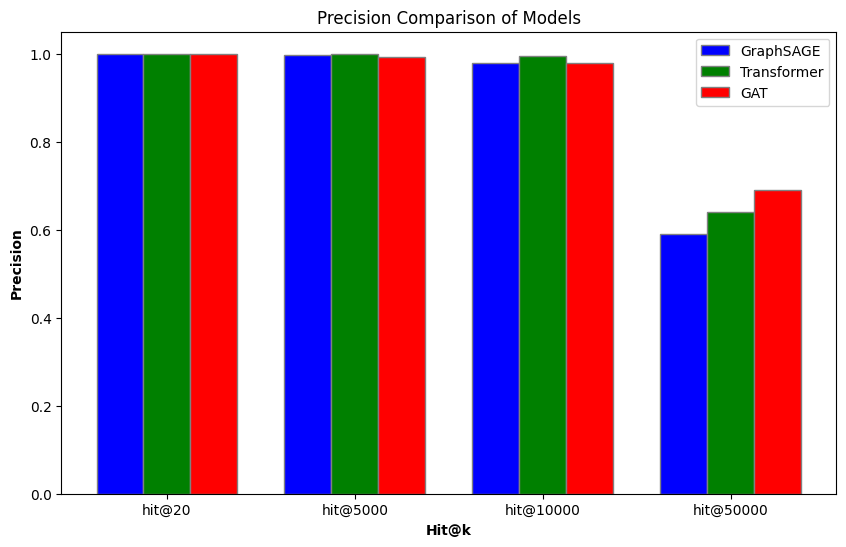

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Extracting the keys and values
x_labels = list(result_sage.keys())
model1_values = list(result_sage.values())
model2_values = list(result_transformer.values())
model3_values = list(result_gat.values())

# Bar width
bar_width = 0.25

# Positions of the bars on the x-axis
r1 = np.arange(len(model1_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, model1_values, color='b', width=bar_width, edgecolor='grey', label='GraphSAGE')
plt.bar(r2, model2_values, color='g', width=bar_width, edgecolor='grey', label='Transformer')
plt.bar(r3, model3_values, color='r', width=bar_width, edgecolor='grey', label='GAT')

# Adding labels
plt.xlabel('Hit@k', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(model1_values))], x_labels)

# Adding legend
plt.legend()

# Display the plot
plt.title('Precision Comparison of Models')
plt.show()